In [ ]:
#IMPORTING MODULES AND STARTING SPARK SESSION

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, trim, lower, isnan, when, sum as sum_, avg
from pyspark.ml.feature import Imputer, VectorAssembler, StringIndexer
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
#IMPORITNG PANDAS AND LIB. FOR PLOTTING

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix


In [ ]:
#SPARK SESSION (START)

spark = SparkSession.builder.appName("WHO_LifeExpectancy_Enhanced").getOrCreate()


In [ ]:
#LOADING DATASET

df = spark.read.csv("/content/Life Expectancy Data.csv", header=True, inferSchema=True)


In [ ]:
#DATA EXPLORATION

df

DataFrame[Country: string, Year: int, Status: string, Life expectancy : double, Adult Mortality: int, infant deaths: int, Alcohol: double, percentage expenditure: double, Hepatitis B: int, Measles : int,  BMI : double, under-five deaths : int, Polio: int, Total expenditure: double, Diphtheria : int,  HIV/AIDS: double, GDP: double, Population: double,  thinness  1-19 years: double,  thinness 5-9 years: double, Income composition of resources: double, Schooling: double]

In [ ]:
#COLUMNS NAMES CLEANING

original_columns = list(df.columns)
new_columns = []
for col_name in original_columns:
    # Replace double spaces with single, then replace spaces with underscore and convert to lower-case.
    new_columns.append(col_name.strip().replace("  ", " ").replace(" ", "_").lower())
df = df.toDF(*new_columns)
print("Cleaned Column Names:")
print(df.columns)

Cleaned Column Names:
['country', 'year', 'status', 'life_expectancy', 'adult_mortality', 'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b', 'measles', 'bmi', 'under-five_deaths', 'polio', 'total_expenditure', 'diphtheria', 'hiv/aids', 'gdp', 'population', 'thinness_1-19_years', 'thinness_5-9_years', 'income_composition_of_resources', 'schooling']


In [ ]:
df

DataFrame[country: string, year: int, status: string, life_expectancy: double, adult_mortality: int, infant_deaths: int, alcohol: double, percentage_expenditure: double, hepatitis_b: int, measles: int, bmi: double, under-five_deaths: int, polio: int, total_expenditure: double, diphtheria: int, hiv/aids: double, gdp: double, population: double, thinness_1-19_years: double, thinness_5-9_years: double, income_composition_of_resources: double, schooling: double]

In [ ]:
# @title DATASET EXPLORATION



In [ ]:
print("Schema:")
df.printSchema()

Schema:
root
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- life_expectancy: double (nullable = true)
 |-- adult_mortality: integer (nullable = true)
 |-- infant_deaths: integer (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- percentage_expenditure: double (nullable = true)
 |-- hepatitis_b: integer (nullable = true)
 |-- measles: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- under-five_deaths: integer (nullable = true)
 |-- polio: integer (nullable = true)
 |-- total_expenditure: double (nullable = true)
 |-- diphtheria: integer (nullable = true)
 |-- hiv/aids: double (nullable = true)
 |-- gdp: double (nullable = true)
 |-- population: double (nullable = true)
 |-- thinness_1-19_years: double (nullable = true)
 |-- thinness_5-9_years: double (nullable = true)
 |-- income_composition_of_resources: double (nullable = true)
 |-- schooling: double (nullable = true)



In [ ]:
print("First 5 Rows:")
df.show(5, truncate=False)

First 5 Rows:
+-----------+----+----------+---------------+---------------+-------------+-------+----------------------+-----------+-------+----+-----------------+-----+-----------------+----------+--------+----------+-----------+-------------------+------------------+-------------------------------+---------+
|country    |year|status    |life_expectancy|adult_mortality|infant_deaths|alcohol|percentage_expenditure|hepatitis_b|measles|bmi |under-five_deaths|polio|total_expenditure|diphtheria|hiv/aids|gdp       |population |thinness_1-19_years|thinness_5-9_years|income_composition_of_resources|schooling|
+-----------+----+----------+---------------+---------------+-------------+-------+----------------------+-----------+-------+----+-----------------+-----+-----------------+----------+--------+----------+-----------+-------------------+------------------+-------------------------------+---------+
|Afghanistan|2015|Developing|65.0           |263            |62           |0.01   |71.279623

In [ ]:
total_rows = df.count()
print("Total number of rows:", total_rows)

Total number of rows: 2938


In [ ]:
print("Descriptive Statistics:")
df.describe().show()

Descriptive Statistics:
+-------+-----------+------------------+----------+-----------------+------------------+------------------+------------------+----------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+--------------------+-------------------+------------------+-------------------------------+------------------+
|summary|    country|              year|    status|  life_expectancy|   adult_mortality|     infant_deaths|           alcohol|percentage_expenditure|       hepatitis_b|           measles|               bmi|under-five_deaths|             polio| total_expenditure|       diphtheria|          hiv/aids|               gdp|          population|thinness_1-19_years|thinness_5-9_years|income_composition_of_resources|         schooling|
+-------+-----------+------------------+----------+-----------------+------------------+------------------+---------

In [ ]:

print("Distinct countries:")
df.select("country").distinct().show(10, truncate=False)

Distinct countries:
+--------------------------------+
|country                         |
+--------------------------------+
|Côte d'Ivoire                   |
|Chad                            |
|Micronesia (Federated States of)|
|Paraguay                        |
|Yemen                           |
|Senegal                         |
|Cabo Verde                      |
|Sweden                          |
|Kiribati                        |
|Republic of Korea               |
+--------------------------------+
only showing top 10 rows



In [ ]:
print("Aggregate: Sum of life_expectancy by country:")
df.groupBy("country").agg(sum_("life_expectancy").alias("total_life_expectancy")).show(5)

Aggregate: Sum of life_expectancy by country:
+--------------------+---------------------+
|             country|total_life_expectancy|
+--------------------+---------------------+
|       Côte d'Ivoire|                806.2|
|                Chad|                806.2|
|Micronesia (Feder...|               1091.2|
|            Paraguay|               1169.8|
|               Yemen|   1021.8000000000001|
+--------------------+---------------------+
only showing top 5 rows



In [ ]:
# @title CHECKING MISSING VALUES


In [ ]:
#CHECKING MISSING VALUES FOR EACH COLUMN IN DATASET

null_counts_raw = {c: df.filter((col(c).isNull()) | isnan(col(c))).count() for c in df.columns}
print("Null values per column (raw):")
print(null_counts_raw)

Null values per column (raw):
{'country': 0, 'year': 0, 'status': 0, 'life_expectancy': 10, 'adult_mortality': 10, 'infant_deaths': 0, 'alcohol': 194, 'percentage_expenditure': 0, 'hepatitis_b': 553, 'measles': 0, 'bmi': 34, 'under-five_deaths': 0, 'polio': 19, 'total_expenditure': 226, 'diphtheria': 19, 'hiv/aids': 0, 'gdp': 448, 'population': 652, 'thinness_1-19_years': 34, 'thinness_5-9_years': 34, 'income_composition_of_resources': 167, 'schooling': 163}


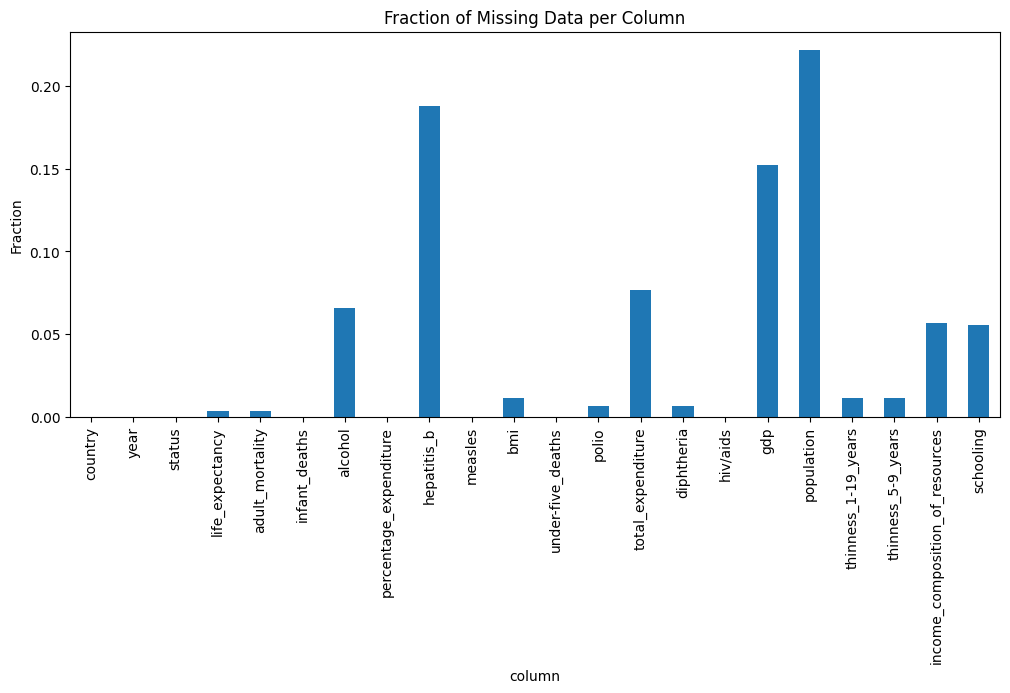

In [ ]:
#VISUALASING MISSING VALUES PER COLUMN

pdf_null = pd.DataFrame({
    "column": list(null_counts_raw.keys()),
    "fraction": [null_counts_raw[c] / total_rows for c in null_counts_raw]
})
pdf_null.set_index("column")["fraction"].plot(kind="bar", figsize=(12, 5), title="Fraction of Missing Data per Column")
plt.ylabel("Fraction")
plt.show()

In [ ]:
#LIST OF ALL COLUMNS TO REPLACE MISSING VALUES WITH MEDIAN

columns_to_impute = [
    "life_expectancy", "adult_mortality", "infant_deaths", "alcohol",
    "percentage_expenditure", "hepatitis_b", "measles", "bmi",
    "under-five_deaths", "polio", "total_expenditure", "diphtheria",
    "hiv/aids", "gdp", "population", "thinness_1-19_years", "thinness_5-9_years",
    "income_composition_of_resources", "schooling"
]

In [ ]:
#USING IMPUTER TOOL TO REPLACE MISSING VALUES WITH MEDIAN OF EACH COLUMN, LEARNING THE MEDIAN VLAUES FROM DATASET AND IMPLEMENTING IN REPLACIN GTHIS VALUES WHERE ARE MISSING

imputer = Imputer(inputCols=columns_to_impute, outputCols=columns_to_impute).setStrategy("median")
df_imputed = imputer.fit(df).transform(df)

In [ ]:
#VERIFICATION ON IMPUTED VALUES

null_counts_after = {c: df_imputed.filter((col(c).isNull()) | isnan(col(c))).count() for c in columns_to_impute}
print("Null counts after imputation:")
print(null_counts_after)

Null counts after imputation:
{'life_expectancy': 0, 'adult_mortality': 0, 'infant_deaths': 0, 'alcohol': 0, 'percentage_expenditure': 0, 'hepatitis_b': 0, 'measles': 0, 'bmi': 0, 'under-five_deaths': 0, 'polio': 0, 'total_expenditure': 0, 'diphtheria': 0, 'hiv/aids': 0, 'gdp': 0, 'population': 0, 'thinness_1-19_years': 0, 'thinness_5-9_years': 0, 'income_composition_of_resources': 0, 'schooling': 0}


In [ ]:
# @title CLEAN DATASED SAVING & CONVERTING TO PANDAS


NameError: name 'pdf_null_after' is not defined

In [ ]:
#SAVING CLEAN DATASET

output_path = "/tmp/life_expectancy_cleaned.csv"
df_imputed.coalesce(1).write.csv(output_path, header=True, mode="overwrite")
print("Cleaned DataFrame saved to:", output_path)


Cleaned DataFrame saved to: /tmp/life_expectancy_cleaned.csv


In [ ]:
#CONVERTING TO PANDAS

df_pd = df_imputed.toPandas()
df_pd.to_csv("life_expectancy_cleaned_pandas.csv", index=False)
print("Pandas DataFrame saved as life_expectancy_cleaned_pandas.csv")


Pandas DataFrame saved as life_expectancy_cleaned_pandas.csv


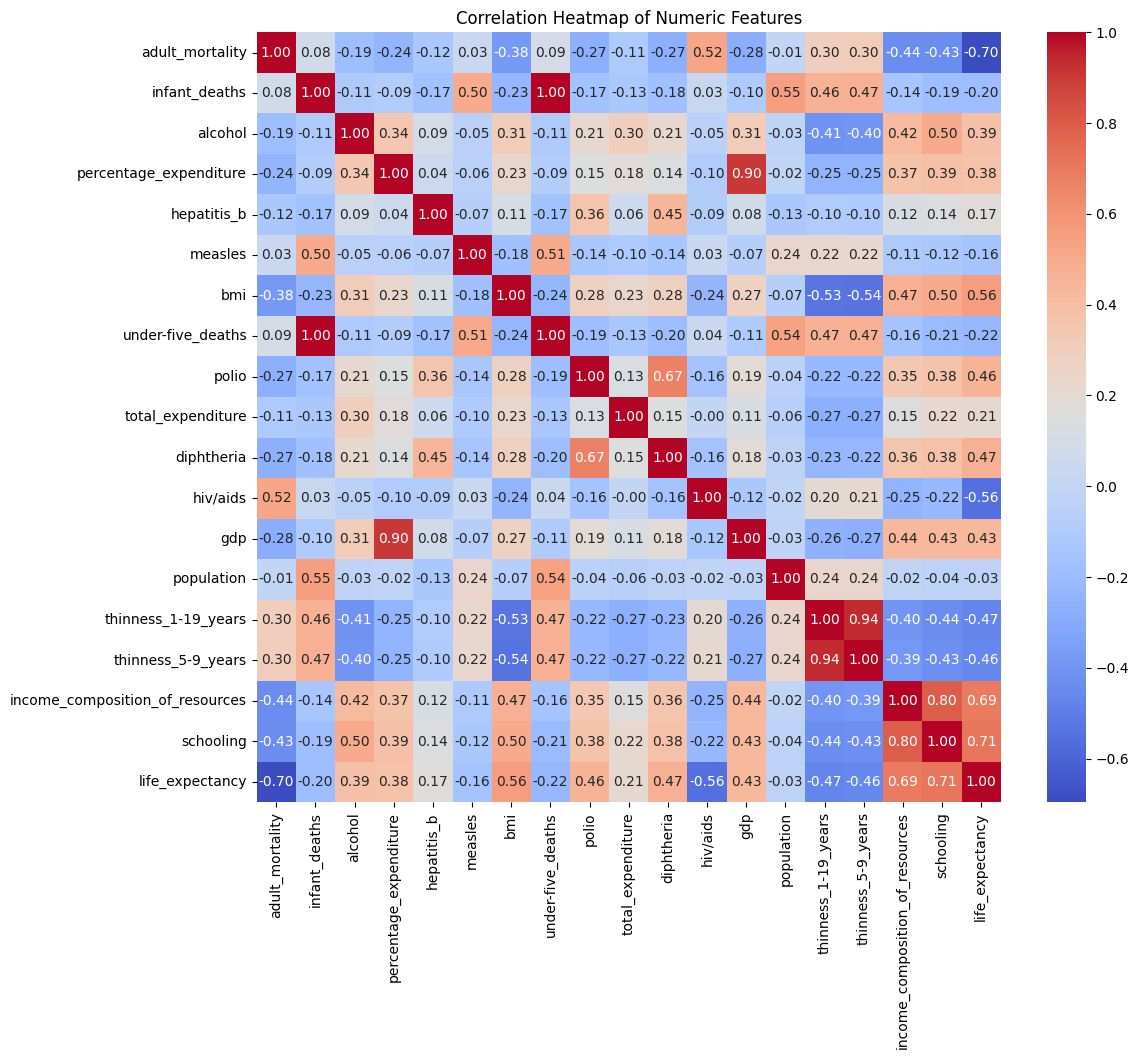

In [ ]:
# @title CORRELATION H-MAP

numeric_columns = [
    "adult_mortality", "infant_deaths", "alcohol", "percentage_expenditure",
    "hepatitis_b", "measles", "bmi", "under-five_deaths", "polio",
    "total_expenditure", "diphtheria", "hiv/aids", "gdp", "population",
    "thinness_1-19_years", "thinness_5-9_years", "income_composition_of_resources",
    "schooling", "life_expectancy"
]
df_numeric = df_imputed.select(numeric_columns)
df_numeric_pd = df_numeric.toPandas()
corr_matrix = df_numeric_pd.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

In [ ]:
#CORRELATION OF EACH FUTURE WITH TARGET VARIABLE

target_corr = corr_matrix["life_expectancy"].drop("life_expectancy")
print("Correlation of each feature with life_expectancy:")
print(target_corr.sort_values(ascending=False))

Correlation of each feature with life_expectancy:
schooling                          0.713054
income_composition_of_resources    0.688662
bmi                                0.556974
diphtheria                         0.472211
polio                              0.458399
gdp                                0.430457
alcohol                            0.388849
percentage_expenditure             0.381418
total_expenditure                  0.208842
hepatitis_b                        0.170219
population                        -0.029018
measles                           -0.157767
infant_deaths                     -0.196769
under-five_deaths                 -0.222738
thinness_5-9_years                -0.462473
thinness_1-19_years               -0.468002
hiv/aids                          -0.556703
adult_mortality                   -0.696390
Name: life_expectancy, dtype: float64


<ipython-input-31-8b4dc9709a10>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr_sorted.index, y=target_corr_sorted.values, palette="viridis")


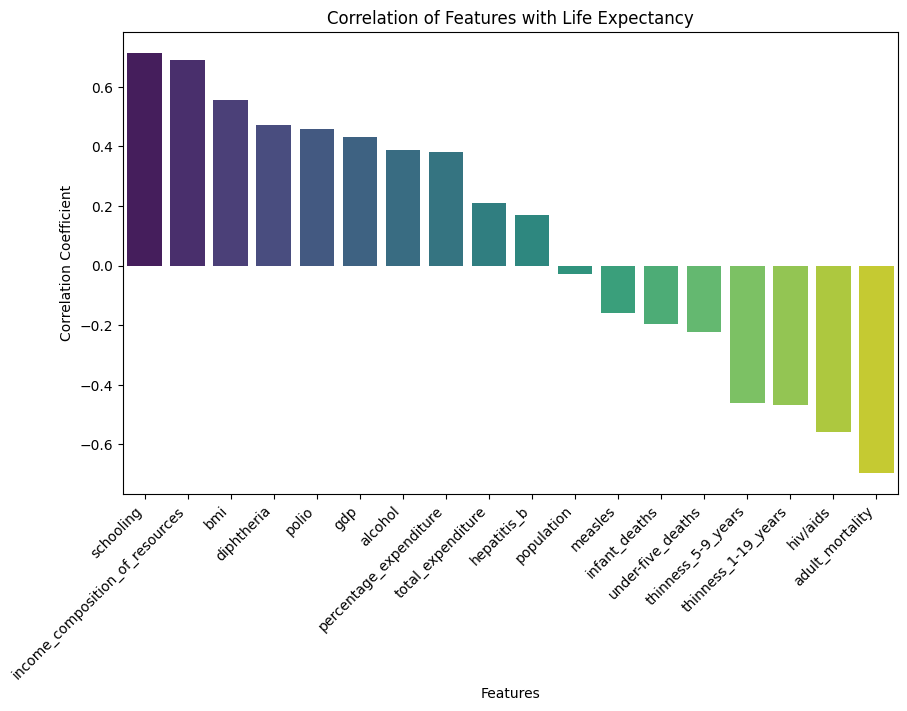

In [ ]:
#BAR CHART OF CORRELATIONS

plt.figure(figsize=(10,6))
target_corr_sorted = target_corr.sort_values(ascending=False)
sns.barplot(x=target_corr_sorted.index, y=target_corr_sorted.values, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Correlation of Features with Life Expectancy")
plt.xlabel("Features")
plt.ylabel("Correlation Coefficient")
plt.show()

In [ ]:
#SCATTERPLOT OF 5 TOP POS & NEGATIVE CORRELEATION FEATURES WITH LIFE EXP.

top_pos = target_corr.sort_values(ascending=False).head(5).index.tolist()
top_neg = target_corr.sort_values().head(5).index.tolist()

print("Top 5 features positively correlated with life_expectancy:", top_pos)
print("Top 5 features negatively correlated with life_expectancy:", top_neg)


Top 5 features positively correlated with life_expectancy: ['schooling', 'income_composition_of_resources', 'bmi', 'diphtheria', 'polio']
Top 5 features negatively correlated with life_expectancy: ['adult_mortality', 'hiv/aids', 'thinness_1-19_years', 'thinness_5-9_years', 'under-five_deaths']


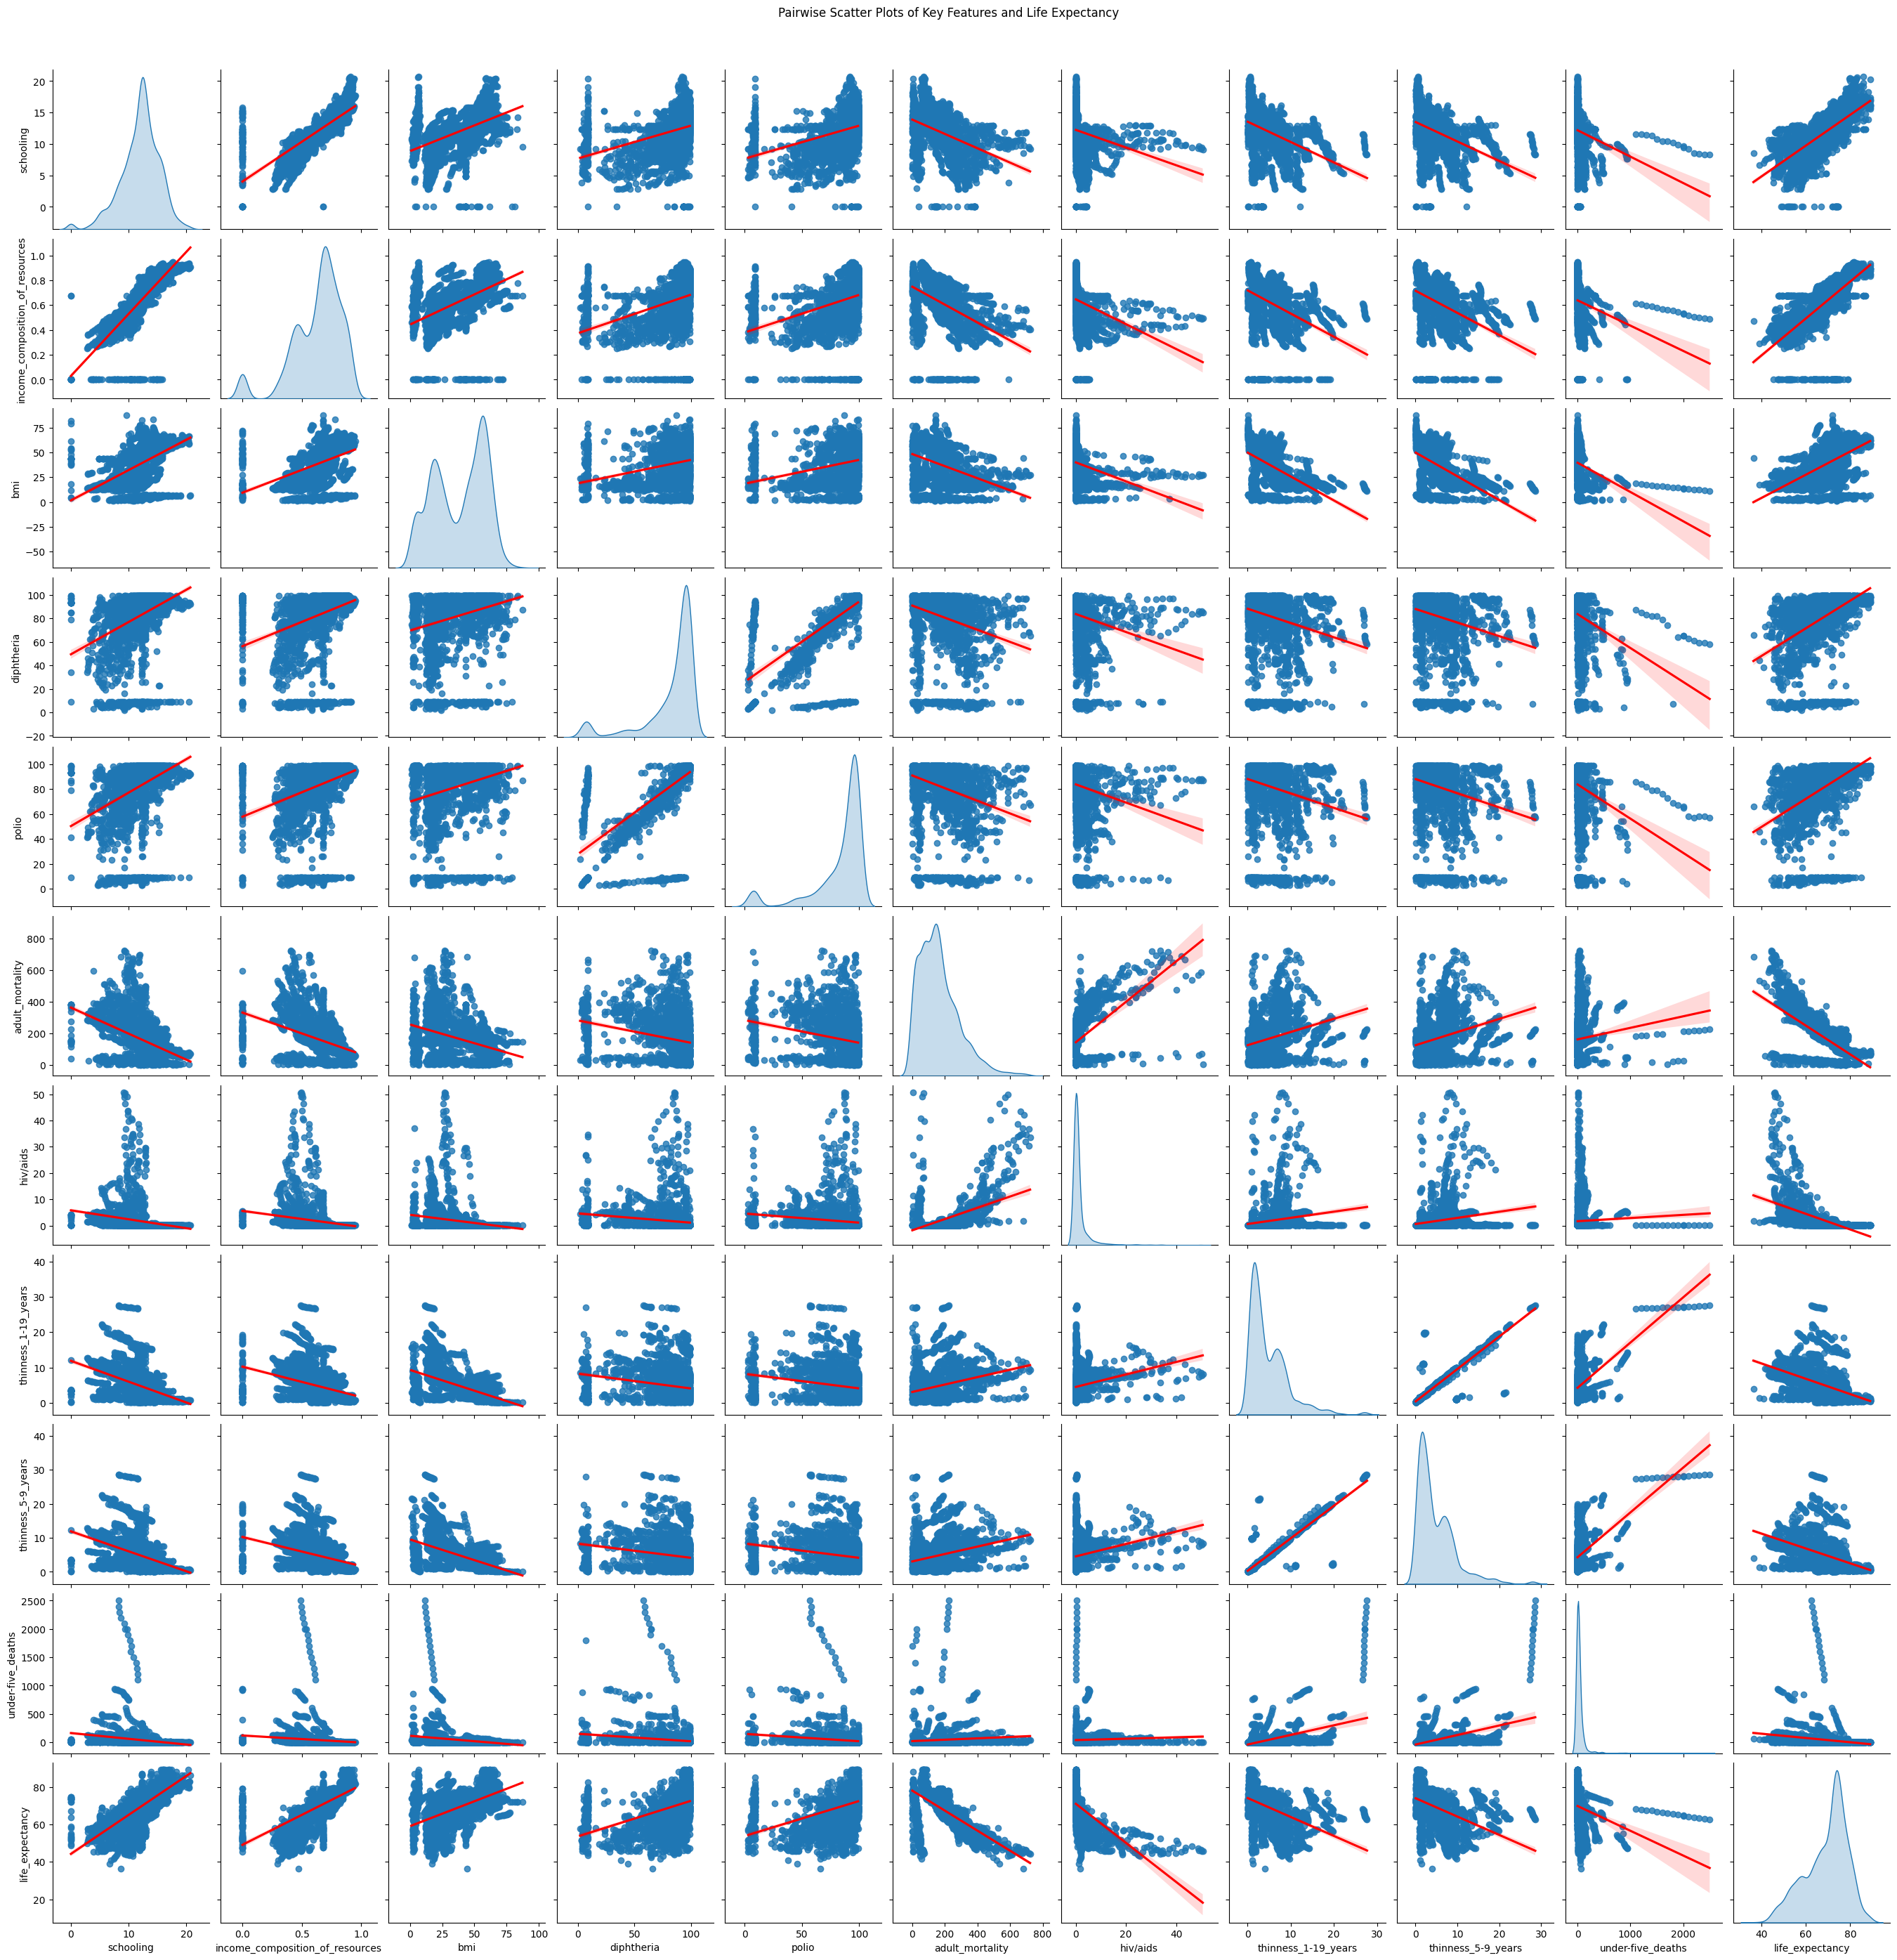

In [ ]:
#VISUALASING TOP 5 POS & NEG FEATURES

selected_features = top_pos + top_neg + ["life_expectancy"]
df_selected = df_numeric_pd[selected_features]
sns.pairplot(df_selected, kind="reg", diag_kind="kde", plot_kws={'line_kws':{'color':'red'}})
plt.suptitle("Pairwise Scatter Plots of Key Features and Life Expectancy", y=1.02)
plt.show()

In [ ]:
# @title ML: REGRESSION AND CLASSIFICATION


In [ ]:

df_imputed.printSchema()
mean_life_exp = df_imputed.select(avg("life_expectancy")).first()[0]
print("Mean life_expectancy:", mean_life_exp)

df_imputed = df_imputed.withColumn("high_lifeexp", when(col("life_expectancy") >= mean_life_exp, 1).otherwise(0))


root
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- life_expectancy: double (nullable = true)
 |-- adult_mortality: integer (nullable = true)
 |-- infant_deaths: integer (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- percentage_expenditure: double (nullable = true)
 |-- hepatitis_b: integer (nullable = true)
 |-- measles: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- under-five_deaths: integer (nullable = true)
 |-- polio: integer (nullable = true)
 |-- total_expenditure: double (nullable = true)
 |-- diphtheria: integer (nullable = true)
 |-- hiv/aids: double (nullable = true)
 |-- gdp: double (nullable = true)
 |-- population: double (nullable = true)
 |-- thinness_1-19_years: double (nullable = true)
 |-- thinness_5-9_years: double (nullable = true)
 |-- income_composition_of_resources: double (nullable = true)
 |-- schooling: double (nullable = true)

Mean life_expectancy: 69.

In [ ]:
#DEFINING FEATURE COLUMNS FOR MODELLING

regression_features = ["adult_mortality", "alcohol", "hepatitis_b", "bmi", "polio",
                       "total_expenditure", "gdp", "population", "income_composition_of_resources", "schooling"]

df_model = df_imputed.dropna(subset=regression_features)
classification_features = regression_features


In [ ]:
df_model = df_imputed.dropna(subset=regression_features)
classification_features = regression_features

In [ ]:
# REGRESSION PIPLINE
assembler_reg = VectorAssembler(inputCols=regression_features, outputCol="features_reg")
# Increase maxBins to 512 to accommodate high cardinality in features like population or gdp.
regressor = DecisionTreeRegressor(featuresCol="features_reg", labelCol="life_expectancy", maxBins=512)
pipeline_regression = Pipeline(stages=[assembler_reg, regressor])

In [ ]:
# CLASSIFICATION PIPELINE
assembler_class = VectorAssembler(inputCols=classification_features, outputCol="features_class")
classifier = LogisticRegression(featuresCol="features_class", labelCol="high_lifeexp", maxIter=20)
pipeline_classification = Pipeline(stages=[assembler_class, classifier])



In [ ]:
#TRAIN TEST SPLIT
train_df, test_df = df_model.randomSplit([0.8, 0.2], seed=42)
print("Training set count:", train_df.count(), "; Test set count:", test_df.count())

model_regression = pipeline_regression.fit(train_df)

Training set count: 2403 ; Test set count: 535


In [ ]:
#TRAINING MODELS

model_regression = pipeline_regression.fit(train_df)
model_classification = pipeline_classification.fit(train_df)

In [ ]:
# @title MODEL PREDICTIONS AND EVALUATION


In [ ]:
#REGRESSION EVALUATION
predictions_reg = model_regression.transform(test_df)
print("Sample Regression Predictions:")
predictions_reg.select("life_expectancy", "features_reg", "prediction").show(5, truncate=False)


Sample Regression Predictions:
+---------------+----------------------------------------------------------------+------------------+
|life_expectancy|features_reg                                                    |prediction        |
+---------------+----------------------------------------------------------------+------------------+
|56.2           |[3.0,0.01,64.0,13.0,36.0,7.76,187.84595,2.1979923E7,0.341,6.2]  |54.226190476190496|
|57.3           |[295.0,0.03,64.0,14.7,58.0,7.43,272.56377,2589345.0,0.405,8.1]  |60.46988636363637 |
|58.1           |[287.0,0.03,64.0,15.7,64.0,8.33,373.3611163,2729431.0,0.433,8.7]|60.46988636363637 |
|59.9           |[268.0,0.01,64.0,18.1,62.0,8.13,631.744976,3.1731688E7,0.47,9.9]|62.667289719626176|
|72.8           |[18.0,4.29,97.0,47.9,97.0,6.27,189.681557,339616.0,0.674,10.7]  |71.58175675675677 |
+---------------+----------------------------------------------------------------+------------------+
only showing top 5 rows



In [ ]:
#RMSE & R²
reg_evaluator_rmse = RegressionEvaluator(labelCol="life_expectancy", predictionCol="prediction", metricName="rmse")
rmse = reg_evaluator_rmse.evaluate(predictions_reg)
reg_evaluator_r2 = RegressionEvaluator(labelCol="life_expectancy", predictionCol="prediction", metricName="r2")
r2 = reg_evaluator_r2.evaluate(predictions_reg)
print("Regression Model - RMSE:", rmse)
print("Regression Model - R²:", r2)

Regression Model - RMSE: 3.586910747650041
Regression Model - R²: 0.8720915185322599


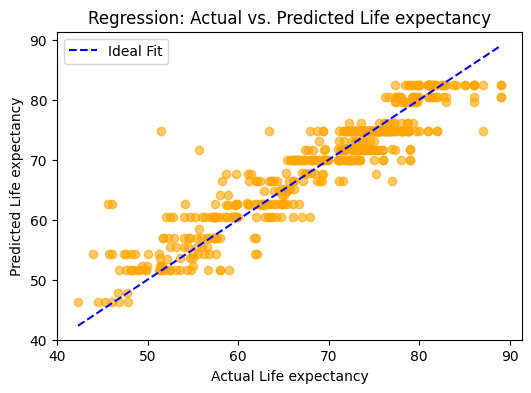

In [ ]:
#PLOT OF ACTUAL VS EXPECTED
preds_reg_pd = predictions_reg.select("life_expectancy", "prediction").toPandas()
plt.figure(figsize=(6,4))
plt.scatter(preds_reg_pd["life_expectancy"], preds_reg_pd["prediction"], alpha=0.6, color="orange")
plt.plot([preds_reg_pd["life_expectancy"].min(), preds_reg_pd["life_expectancy"].max()],
         [preds_reg_pd["life_expectancy"].min(), preds_reg_pd["life_expectancy"].max()],
         color="blue", linestyle="--", label="Ideal Fit")
plt.xlabel("Actual Life expectancy")
plt.ylabel("Predicted Life expectancy")
plt.title("Regression: Actual vs. Predicted Life expectancy")
plt.legend()
plt.show()

In [ ]:
#CLASSIFICATION EVALUATION

predictions_class = model_classification.transform(test_df)
print("Sample Classification Predictions:")
predictions_class.select("High_LifeExp", "features_class", "prediction").show(5, truncate=False)

Sample Classification Predictions:
+------------+----------------------------------------------------------------+----------+
|High_LifeExp|features_class                                                  |prediction|
+------------+----------------------------------------------------------------+----------+
|0           |[3.0,0.01,64.0,13.0,36.0,7.76,187.84595,2.1979923E7,0.341,6.2]  |0.0       |
|0           |[295.0,0.03,64.0,14.7,58.0,7.43,272.56377,2589345.0,0.405,8.1]  |0.0       |
|0           |[287.0,0.03,64.0,15.7,64.0,8.33,373.3611163,2729431.0,0.433,8.7]|0.0       |
|0           |[268.0,0.01,64.0,18.1,62.0,8.13,631.744976,3.1731688E7,0.47,9.9]|0.0       |
|1           |[18.0,4.29,97.0,47.9,97.0,6.27,189.681557,339616.0,0.674,10.7]  |1.0       |
+------------+----------------------------------------------------------------+----------+
only showing top 5 rows



In [ ]:
#EVALUATION USING ROC AUC, ACCURACY AND F1 SCORE

cls_evaluator_roc = BinaryClassificationEvaluator(labelCol="high_lifeexp", metricName="areaUnderROC")
roc_auc_cls = cls_evaluator_roc.evaluate(predictions_class)
print("Classification Model - Area Under ROC:", roc_auc_cls)

cls_evaluator_acc = MulticlassClassificationEvaluator(labelCol="high_lifeexp", metricName="accuracy")
accuracy_cls = cls_evaluator_acc.evaluate(predictions_class)
cls_evaluator_f1 = MulticlassClassificationEvaluator(labelCol="high_lifeexp", metricName="f1")
f1_cls = cls_evaluator_f1.evaluate(predictions_class)
print("Classification Model - Accuracy:", accuracy_cls)
print("Classification Model - F1 Score:", f1_cls)


Classification Model - Area Under ROC: 0.9716230905658237
Classification Model - Accuracy: 0.9046728971962616
Classification Model - F1 Score: 0.9047001505446912


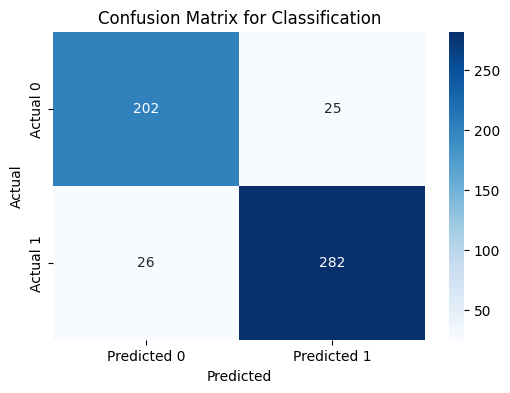

In [ ]:
preds_cls_pd = predictions_class.select("high_lifeexp", "prediction").toPandas()
cm = confusion_matrix(preds_cls_pd["high_lifeexp"], preds_cls_pd["prediction"])
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.title("Confusion Matrix for Classification")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

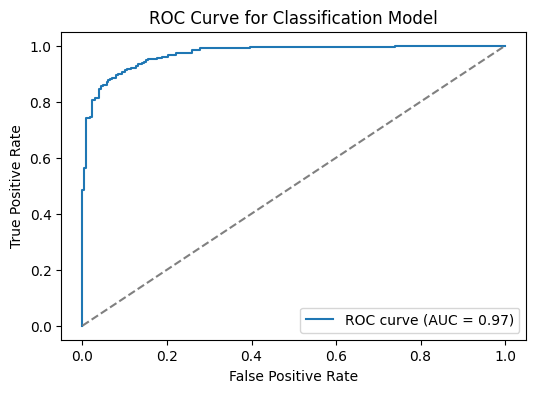

In [ ]:
#PLOTTING ROC CURVE

preds_cls_pd["probability"] = predictions_class.select("probability").toPandas()["probability"].apply(lambda x: float(x[1]))
fpr, tpr, thresholds = roc_curve(preds_cls_pd["high_lifeexp"], preds_cls_pd["probability"])
roc_auc_value = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_value:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Classification Model")
plt.legend(loc="lower right")
plt.show()

In [ ]:
print("=== Final Evaluation Summary ===")
print("Regression Metrics:")
print(f"  - RMSE: {rmse:.2f}")
print(f"  - R²: {r2:.2f}")
print("Classification Metrics:")
print(f"  - ROC AUC: {roc_auc_cls:.2f}")
print(f"  - Accuracy: {accuracy_cls:.2f}")
print(f"  - F1 Score: {f1_cls:.2f}")


=== Final Evaluation Summary ===
Regression Metrics:
  - RMSE: 3.59
  - R²: 0.87
Classification Metrics:
  - ROC AUC: 0.97
  - Accuracy: 0.90
  - F1 Score: 0.90


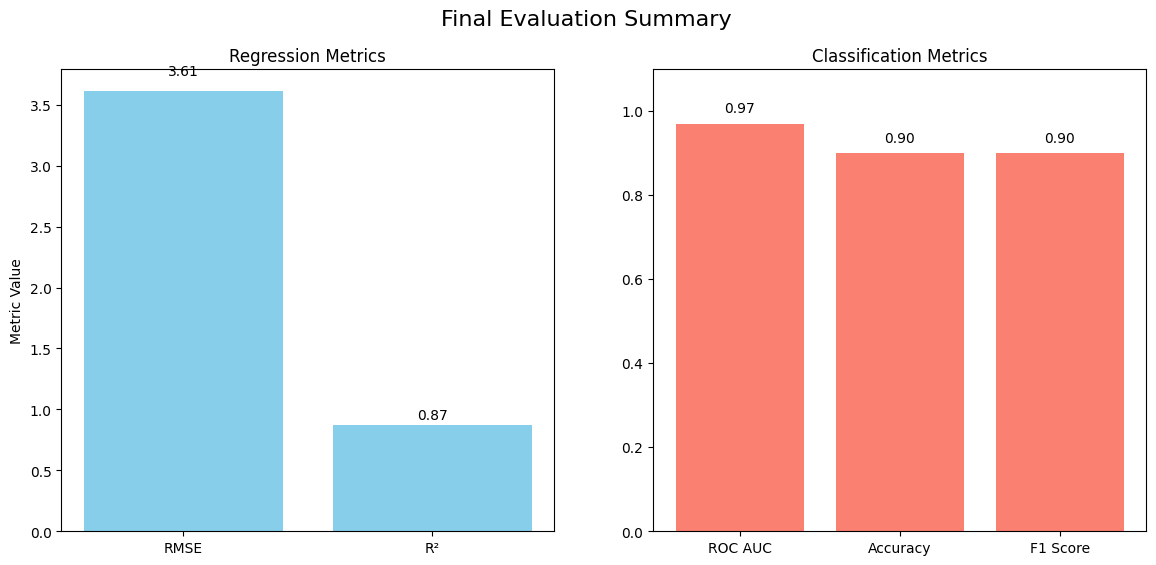

Interpretation & Insights:
Regression:
  - RMSE of 3.61 indicates that, on average, the model's predictions are off by about 3.61 years from the actual life expectancy.
  - An R² of 0.87 shows that approximately 87% of the variance in life expectancy is captured by the model.
Classification:
  - A ROC AUC of 0.97 indicates excellent discriminative power between high and low life expectancy groups.
  - Accuracy of 0.90 and an F1 Score of 0.90 demonstrate strong overall performance and balance in the classification model.


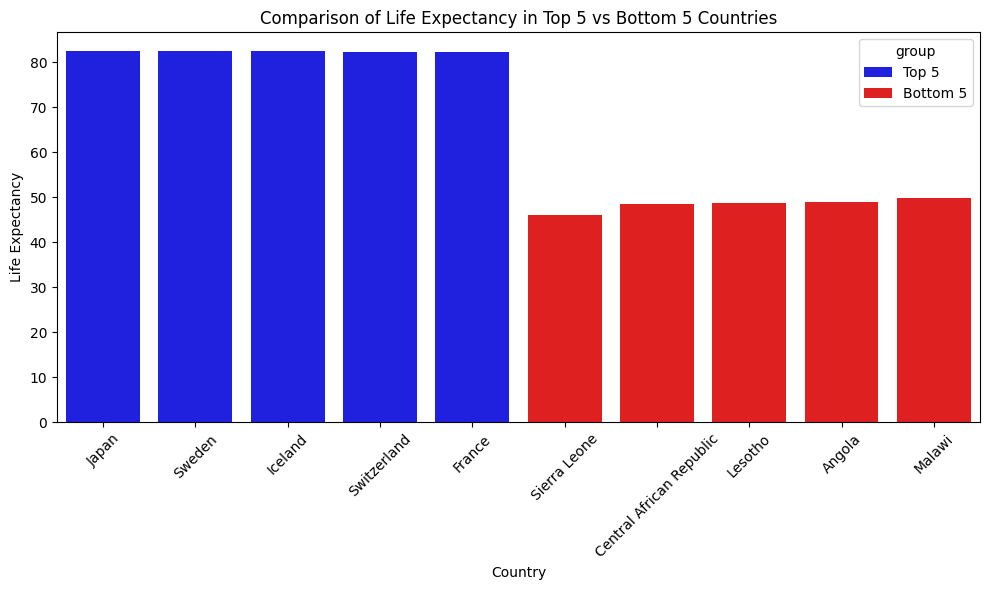

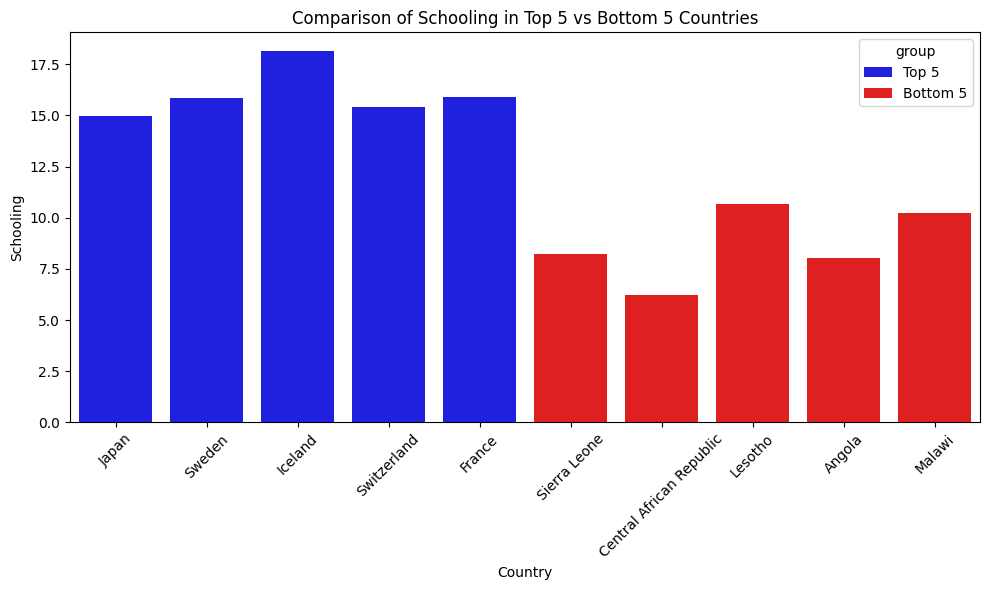

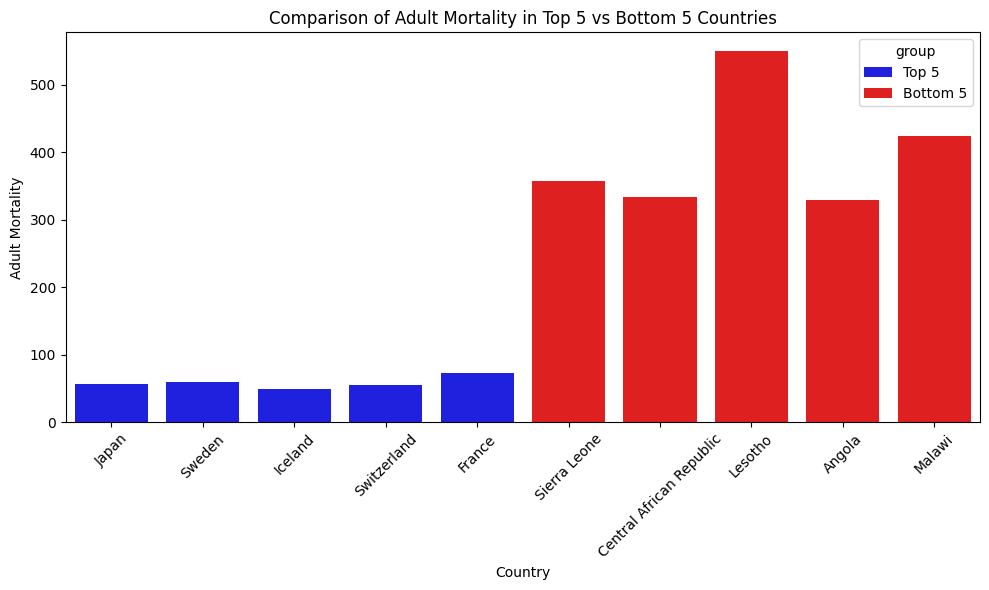

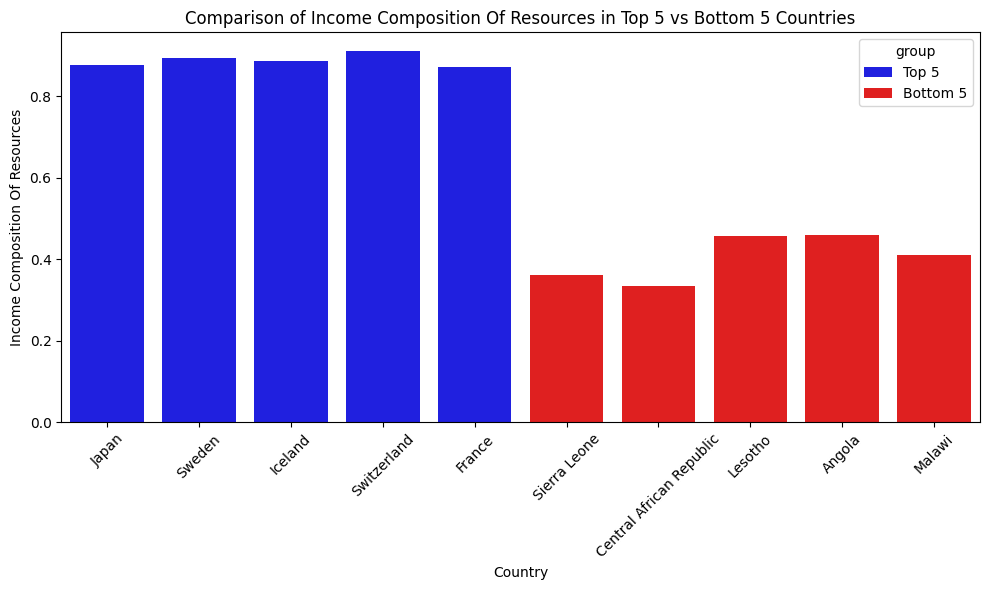

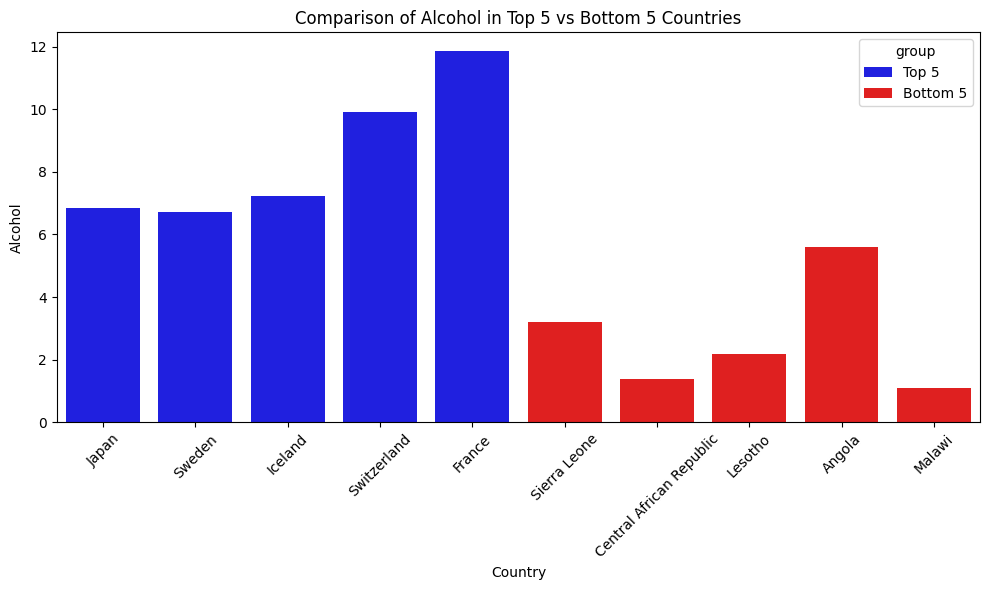

In [ ]:


# metrics

regression_metrics = {'RMSE': rmse, 'R²': r2}
classification_metrics = {'ROC AUC': roc_auc_cls, 'Accuracy': accuracy_cls, 'F1 Score': f1_cls}

# two side-by-side subplots.

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Regression Metrics

axes[0].bar(regression_metrics.keys(), regression_metrics.values(), color='skyblue')
axes[0].set_title('Regression Metrics')
axes[0].set_ylabel('Metric Value')


# bar with its value

for i, metric in enumerate(regression_metrics.keys()):
    axes[0].text(i, regression_metrics[metric] + 0.03*regression_metrics[metric], f"{regression_metrics[metric]:.2f}",
                 ha='center', va='bottom')

# Classification Metrics

axes[1].bar(classification_metrics.keys(), classification_metrics.values(), color='salmon')
axes[1].set_title('Classification Metrics')
axes[1].set_ylim(0, 1.1)


for i, metric in enumerate(classification_metrics.keys()):
    axes[1].text(i, classification_metrics[metric] + 0.02, f"{classification_metrics[metric]:.2f}",
                 ha='center', va='bottom')

fig.suptitle("Final Evaluation Summary", fontsize=16)
plt.show()

print("Interpretation & Insights:")
print("Regression:")
print("  - RMSE of {:.2f} indicates that, on average, the model's predictions are off by about {:.2f} years from the actual life expectancy.".format(rmse, rmse))
print("  - An R² of {:.2f} shows that approximately {:.0f}% of the variance in life expectancy is captured by the model.".format(r2, r2*100))
print("Classification:")
print("  - A ROC AUC of {:.2f} indicates excellent discriminative power between high and low life expectancy groups.".format(roc_auc_cls))
print("  - Accuracy of {:.2f} and an F1 Score of {:.2f} demonstrate strong overall performance and balance in the classification model.".format(accuracy_cls, f1_cls))


# Comparative Analysis: Top vs Bottom Countries

new_df = pd.read_csv("life_expectancy_cleaned_pandas.csv")
country_summary = new_df.groupby("country")[["life_expectancy", "schooling", "adult_mortality",
                                               "income_composition_of_resources", "alcohol"]].mean().reset_index()

# countries by life_expectancy

top5 = country_summary.sort_values(by="life_expectancy", ascending=False).head(5)
bottom5 = country_summary.sort_values(by="life_expectancy", ascending=True).head(5)

# group labels

top5["group"] = "Top 5"
bottom5["group"] = "Bottom 5"
combined = pd.concat([top5, bottom5])

# Plot grouped bar charts for key features

features_to_plot = ["life_expectancy", "schooling", "adult_mortality", "income_composition_of_resources", "alcohol"]

for feature in features_to_plot:
    plt.figure(figsize=(10,6))
    sns.barplot(x="country", y=feature, hue="group", data=combined, palette={"Top 5": "blue", "Bottom 5": "red"})
    plt.title(f"Comparison of {feature.replace('_', ' ').title()} in Top 5 vs Bottom 5 Countries")
    plt.xlabel("Country")
    plt.ylabel(feature.replace("_", " ").title())
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
spark.stop()